In [1]:
from Helpers import *
from FLController import *
from ILQGController import *
from LQGController import *

In [2]:
def VerifyVel(X0 = [70,70],XN=[-10,100],less = 0,timings = [.5,.75,1],onlyILQG=False):
    start = ToCartesian(np.array(X0)/180*pi)
    end = ToCartesian(np.array(XN)/180*pi)
    plt.figure(dpi=100,figsize = (8,8))
    plt.scatter([end[0]],[end[1]],s= 50,color = "black")
    for timing in timings:
        K = int(timing/.01)
        xILQG,yILQG,uILQG,x = ILQG(timing,1e7,1e4,1e-4,end,K-less,start,Delay=0,plot = False)
        plt.plot(xILQG,yILQG,label = f"{int(timing*1000)}ms ILQG",color = (0.4*timing*1.5,0.8*(1.2-timing),0.2))
        if onlyILQG==True: plt.axis("equal")
        if onlyILQG==False : X,Y = Feedback_Linearization(timing,1e7,1e7,1e4,1e4,1e-4,1e-4,end,start,Num_iter=K,Delay = 0)
    plt.plot(np.linspace(start[0],end[0],100),np.linspace(start[1],end[1],100),color = "grey",alpha = .4,linestyle = "--")
    MultipleLabel()
    if end[1]>end[0]: 
        ax = plt.gca()  # Get current axes
        legend = ax.get_legend()
        legend.set_bbox_to_anchor((1, 0.3))  # Moves the legend to the right of the plot
    plt.show()
    plt.figure(figsize = (8,8))
    for timing in timings:
        K = int(timing/.01)
        xILQG,yILQG,uILQG,x = ILQG(timing,1e7,1e4,1e-4,end,K-less,start,Delay=0,plot=False)
        plt.plot(np.linspace(0,timing,x.shape[0]),x[:,2],label = "Shoulder ILQG",color = (0.51,0.25,0.7),linestyle = "-.")
        plt.plot(np.linspace(0,timing,x.shape[0]),x[:,3],label = "Elbow ILQG",color = (0.51,0.25,0.7))
        plt.plot(np.linspace(0,timing,100),np.zeros(100),color = "grey",linestyle = "--",linewidth = 1)
        if onlyILQG == False:
            X,Y,J,x = Feedback_Linearization(timing,1e7,1e7,1e4,1e4,1e-4,1e-4,end,start,Num_iter=K,plot = False,ShowJ=True)
            plt.plot(np.linspace(0,timing,x.shape[0]),x[:,2],label = "Shoulder FL",color = (0.44,0.91,0.86),linestyle = "-.")
            plt.plot(np.linspace(0,timing,x.shape[0]),x[:,3],label = "Elbow FL",color = (0.44,0.91,0.86))
            plt.plot(np.linspace(0,timing,100),np.zeros(100),linestyle = "--",linewidth = 1)
        MultipleLabel(title = "Velocity")
    plt.ylabel("Angular velocity [rad/s]")
    plt.xlabel("Time [sec]")
    ax = plt.gca()  # Get current axes
    legend = ax.get_legend()
    legend.set_bbox_to_anchor((1, 0.3))  # Moves the legend to the right of the plot

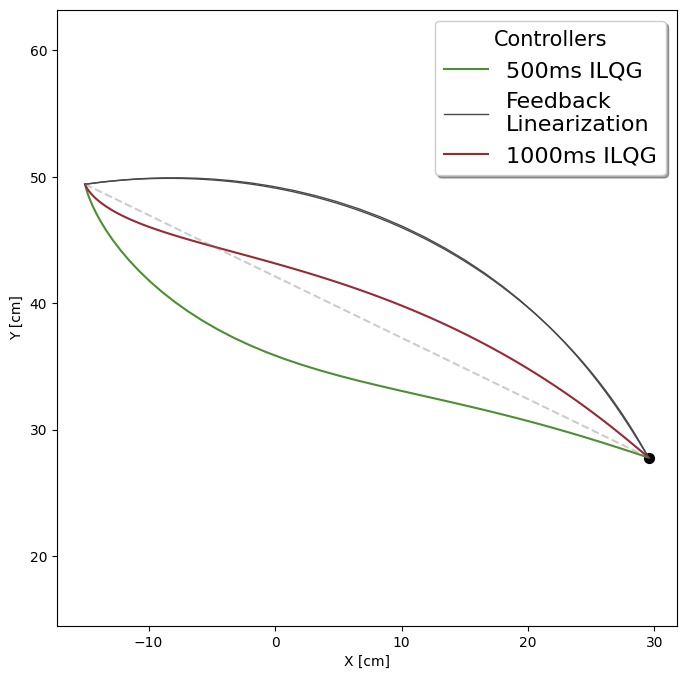

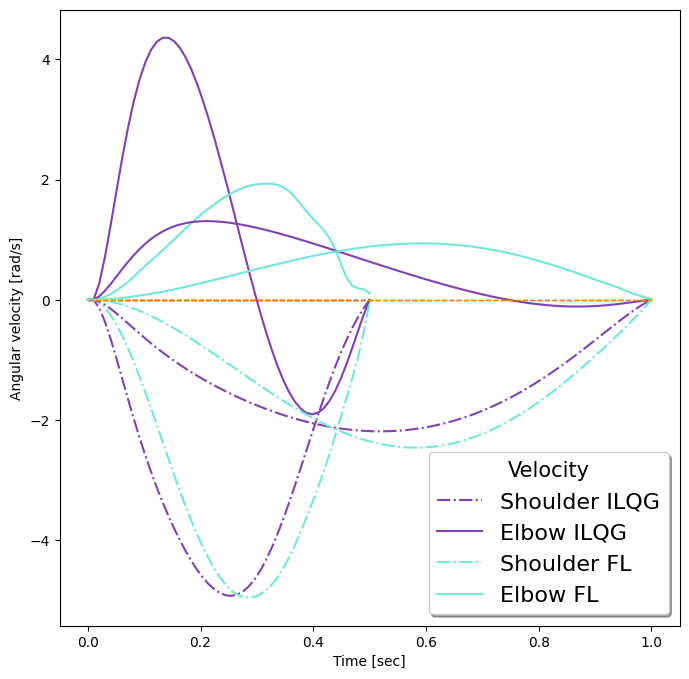

In [3]:
VerifyVel(timings= [0.5,1])

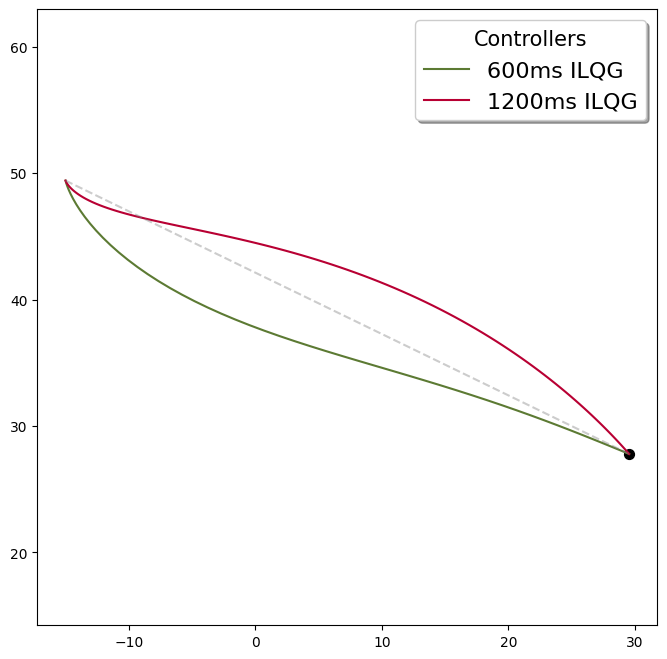

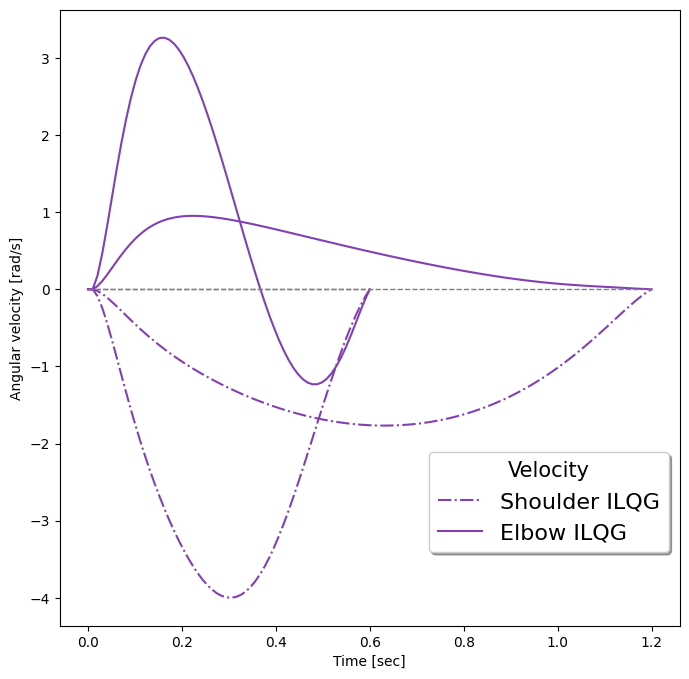

In [4]:
VerifyVel(timings=[.6,1.2],onlyILQG=True)

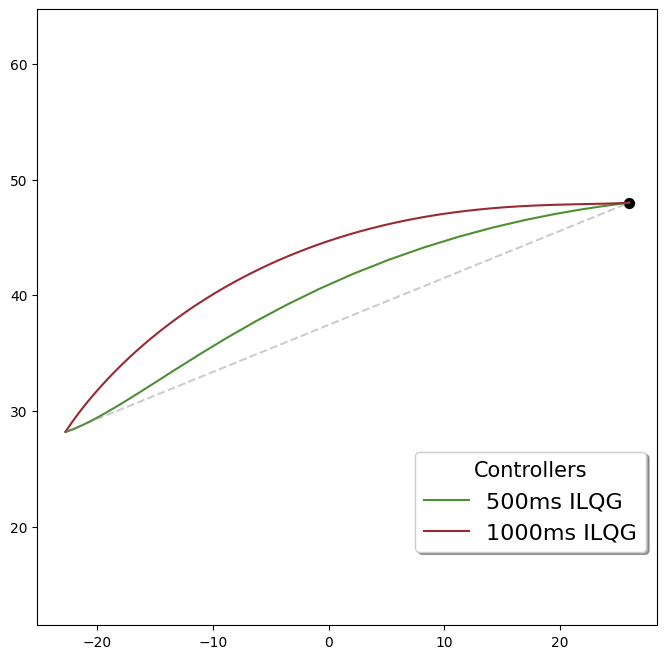

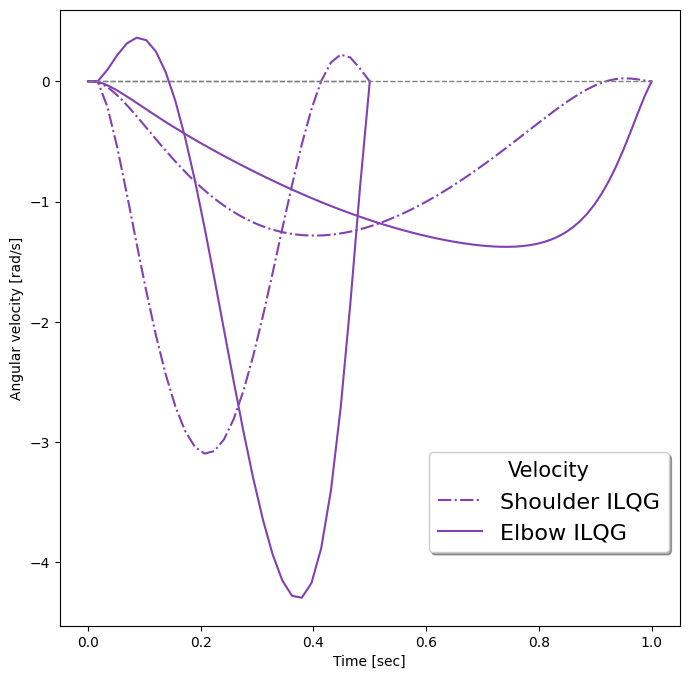

In [5]:
VerifyVel([70,110],[30,60],less = 20,timings=[.5,1],onlyILQG=True)


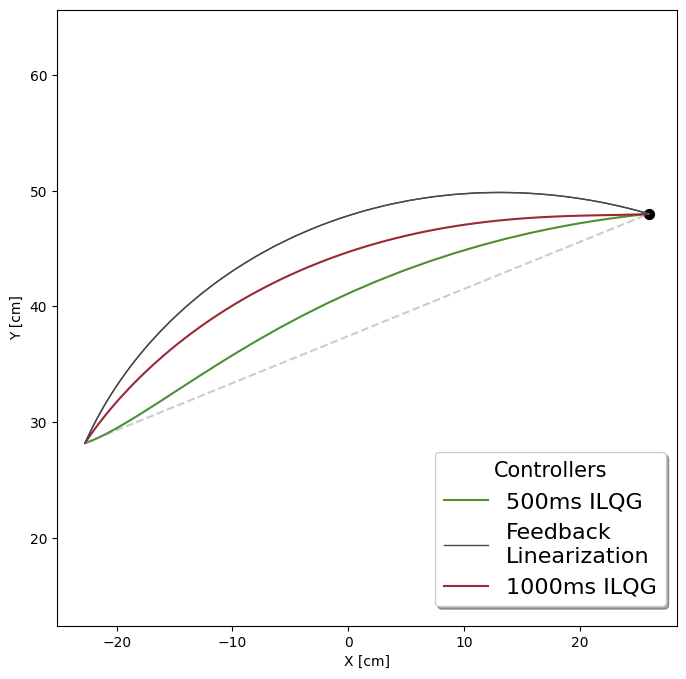

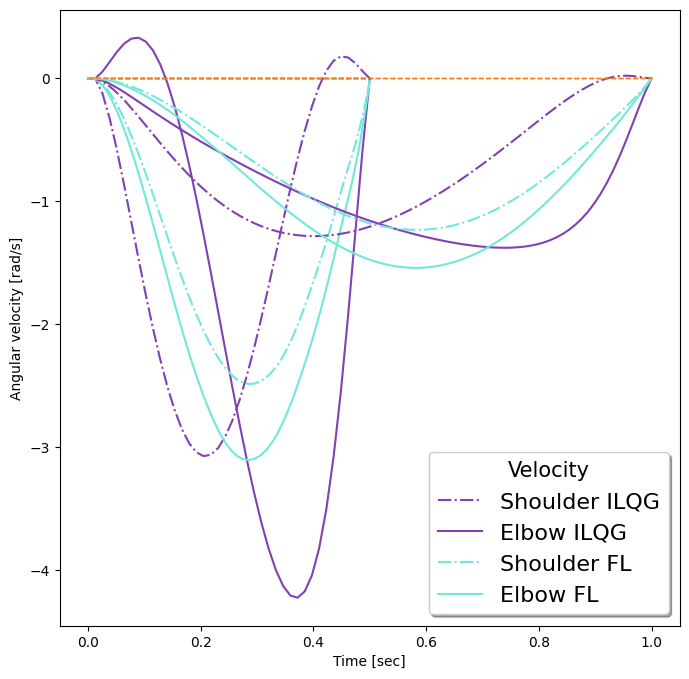

In [6]:
VerifyVel([70,110],[30,60],less = 10,timings = [.5,1])


In [7]:
def Feedback_Linearization_Stab(Duration = .6,w1 = 1e8,w2 = 1e8,w3 = 1e4,w4 = 1e4,r1 = 1e-5,r2 = 1e-5,targets = [0,55],starting_point = [0,30],plot = True,PlottingFunction=PlotTraj ,Activate_Noise = False,Num_iter = 300,Showu=False, ShowJ = False, ShowEstimate = False,Delay = .06,AdditionalDynamics = {},Stabilization_Time = 0):
    
    """
    Duration (float) : Duration of the movement

    w1 (float) : Weight associated to the penalty on shoulder angle 
    
    w2 (float) : Weight associated to the penalty on elbow angle 

    w3 (float) : Weight associated to the penalty on shoulder angular velocity

    w4 (float) : Weight associated to the penalty on elbow angular velocity

    r1 (float) : Weight associated to the motor cost on shoulder torques

    r2 (float) : Weight associated to the motor cost on elbow torques

    targets (array of float of size 2): X,Y Position of the end point of the movement
        must be a biomechanically feasible end point considering that the shoulder is at (0,0)

    starting_point (array of float of size 2): X,Y Position of the starting point of the movement
        must be a biomechanically feasible starting point considering that the shoulder is at (0,0)
    
    plot (boolean) : Allowing plot outputs of the hand trajectory for the experiment

    Activate_Noise (boolean) : Gaussian variance associated to the white noises in the model

    Num_iter (int) : Number of simulations steps

    ShowJ (boolean) : Computes and print the total cost function generated by the controller at the end of the movement

    ShowEstimate (boolean) : Plot the estimated trajectory by the controller instead of the true trajectory

    Delay (float) : Internal Delay of the system in seconds

    AdditionalDynamics (dic) : Keywords describing supplementary environmental dynamics in the simulations 

        1) Velocity dependent ForceFields : 

            - FF (Boolean) : Describing whether there is a forcefield or not 
            - FFOnset (float) : Y threshold in cm after which the forcefield is activated 
            - Side (string: Left or Right ) : Describing on which side the lateral forcefield happen
    """

    dt = (Duration+Stabilization_Time)/Num_iter 
    kdelay = int(Delay/dt)
    kstab= int(Stabilization_Time/dt)

    obj1,obj2 = newton(newtonf,newtondf,1e-8,1000,targets[0],targets[1]) #Defini les targets
    st1,st2 = newton(newtonf,newtondf,1e-8,1000,starting_point[0],starting_point[1])

    x0 = np.array([st1,0,0,st2,0,0,obj1,obj2])
    x0_with_delay = np.tile(x0, kdelay + 1) 

    Num_Var = 8
    
    #Define Weight Matrices of the cost function
    R = np.array([[r1,0],[0,r2]])
    Q = np.array([[w1,0,0,0,0,0,-w1,0],[0,w3,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
               [0,0,0,w2,0,0,0,-w2],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
               [-w1,0,0,0,0,0,w1,0],[0,0,0,-w2,0,0,0,w2]])

    
    
    #Define the Dynamic of the linear system 

    Kfactor = 1/0.06

    A_basic = np.array([[1,dt,0,0,0,0,0,0],[0,1,dt,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,dt,0,0,0],[0,0,0,0,1,dt,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]])
    B_basic = np.array([[0,0],[0,0],[dt,0],[0,0],[0,0],[0,dt],[0,0],[0,0]])
    sigma = np.zeros((Num_Var*(kdelay+1),Num_Var*(kdelay+1)))

    #Incorporation of delay 

    H = np.zeros((Num_Var,(kdelay+1)*Num_Var))
    H[:,(kdelay)*Num_Var:]= np.identity(Num_Var)

    A = np.zeros(((kdelay+1)*Num_Var,(kdelay+1)*Num_Var))
    A[:Num_Var,:Num_Var] = A_basic
    A[Num_Var:,:-Num_Var] = np.identity((kdelay)*Num_Var)
    B = np.zeros(((kdelay+1)*Num_Var,2))
    B[:Num_Var] = B_basic

    #Compute the Feedback Gain of the Control law
    S = np.copy(Q)

    array_L = np.zeros((Num_iter-1,2,Num_Var))   
    array_S = np.zeros((Num_iter,Num_Var,Num_Var)) 
    array_S[-1] = S
    for k in range(Num_iter-1):
        L = np.linalg.inv(R+B_basic.T@S@B_basic)@B_basic.T@S@A_basic
        array_L[Num_iter-2-k] = L
        Qk = np.copy(Q) if k < (kstab-100) else np.zeros(Q.shape)
        S = Qk+A_basic.T@S@(A_basic-B_basic@L)
        array_S[Num_iter-2-k] = S
        
    #Initialize matrices 
    L = array_L


    #Initialize the arrays to stock the simulations 
    array_zhat = np.zeros((Num_iter,Num_Var))
    array_x = np.zeros((Num_iter,Num_Var-2)) 
    array_z = np.zeros((Num_iter,Num_Var)) 
    array_u = np.zeros((Num_iter-1,2))
    y = np.zeros((Num_iter-1,Num_Var))

    #Initialize the state vectors of the linear system
    array_zhat[0] = x0.flatten()
    array_z[0] = x0.flatten()
    zhat = np.copy(x0_with_delay)
    z =  np.copy(x0_with_delay)

    #Initialize the state vectors of the nonlinear system
    x = np.zeros(Num_Var-2)
    x[0],x[1] = x0[0],x0[3]
    new_x = np.copy(x)

    #Incorporation of delay 

    #Perform the task
    J = 0
    acc = np.zeros(2)
    for k in range(Num_iter-1):
        #Compute the matrices of the FL technique in function of the current estimate state 
        
        F = EnvironmentDynamics(AdditionalDynamics,x,acc)

        C = np.array([-zhat[4]*(2*zhat[1]+zhat[4])*a2*np.sin(zhat[3]),zhat[1]*zhat[1]*a2*np.sin(zhat[3])])

        M = np.array([[a1+2*a2*cos(zhat[3]),a3+a2*cos(zhat[3])],[a3+a2*cos(zhat[3]),a3]])

        Cdot = np.array([-a2*zhat[5]*(2*zhat[1]+zhat[4])*sin(zhat[3])-a2*zhat[4]*(2*zhat[2]+zhat[5])*sin(zhat[3])
                         -a2*zhat[4]*zhat[4]*(2*zhat[1]+zhat[4])*cos(zhat[3]),2*zhat[1]*zhat[2]*a2*sin(zhat[3])+zhat[1]*zhat[1]*a2*cos(zhat[3])*zhat[4]])

        Mdot = np.array([[-2*a2*sin(zhat[3])*zhat[4],-a2*sin(zhat[3])*zhat[4]],[-a2*sin(zhat[3])*zhat[4],0]])
        
        Omega_motor,Omega_measure,motornoise,sensorynoise = NoiseAndCovMatrix(M,Num_Var,kdelay)

        # Compute the command through the FL technique
        
        v = -L[k].reshape(np.flip(B_basic.shape))@zhat[:Num_Var]
        u = 1/Kfactor*M@(v)+1/Kfactor*Mdot@(np.array([zhat[2],zhat[5]]))+M@(np.array([zhat[2],zhat[5]]))+C+Bdyn@np.array([zhat[1],zhat[4]])+1/Kfactor*Cdot+1/Kfactor*Bdyn@np.array([zhat[2],zhat[5]])
        array_u[k] = u
        if ShowJ : J+= u.T@R@u

        # Delayed Observation of the Nonlinear system expressed in linear coordinates
        
        y[k] = (H@z).flatten()
        if Activate_Noise : 

            y[k]+=sensorynoise
        
        # Kalman Filter Gains 

        K = A@sigma@H.T@np.linalg.inv(H@sigma@H.T+Omega_measure)
        sigma = Omega_motor + (A - K@H)@sigma@A.T

        # Compute the Estimation of the system in the linear system
        
        zhat = A@zhat + B@v + K@(y[k]-H@zhat)
        
        # Simulate the nonlinear plant 
        
        C = np.array([-x[3]*(2*x[2]+x[3])*a2*np.sin(x[1]),x[2]*x[2]*a2*np.sin(x[1])])
        
        M = np.array([[a1+2*a2*cos(x[1]),a3+a2*cos(x[1])],[a3+a2*cos(x[1]),a3]])

        
        Cdot = np.array([-a2*acc[1]*(2*x[2]+x[3])*sin(x[1])-a2*x[3]*(2*acc[0]+acc[1])*sin(x[1])
                         -a2*x[3]*x[3]*(2*x[2]+x[3])*cos(x[1]),2*x[2]*acc[0]*a2*sin(x[1])+x[2]*x[2]*a2*cos(x[1])*x[3]])

        Mdot = np.array([[-2*a2*sin(x[1])*x[3],-a2*sin(x[1])*x[3]],[-a2*sin(x[1])*x[3],0]])
        
        new_x[0:2] += dt*x[2:4]
        new_x[2:4] += dt*(np.linalg.solve(M,(x[4:6]-Bdyn@(x[2:4])-C))+F)
        new_x[4:6] += dt*Kfactor*(u-x[4:6])

        if Activate_Noise : 

            new_x[4:6]+=motornoise
        
        z = np.concatenate((np.array([new_x[0],new_x[2],acc[0],new_x[1],new_x[3],acc[1],z[6],z[7]]),z[:-Num_Var]))
        
        # Transform the new nonlinear state into the coordinates of the linear system
        C = np.array([-z[4]*(2*z[1]+z[4])*a2*np.sin(z[3]),z[1]*z[1]*a2*np.sin(z[3])])

        M = np.array([[a1+2*a2*cos(z[3]),a3+a2*cos(z[3])],[a3+a2*cos(z[3]),a3]])

        acc = np.linalg.solve(M,(new_x[4:6]-Bdyn@(new_x[2:4])-C))+F
        #Stock the true and estimated states

        array_z[k+1] = z[:Num_Var].flatten()
        array_zhat[k+1] = zhat[:Num_Var].flatten()
        array_x[k+1] = new_x[:Num_Var-2].flatten()
        
        x = np.copy(new_x)
        

    if ShowJ : 
        J+= z[:8].T@Q@z[:8]

    #Change of coordinates from angular to cartesian 
    

    data = array_z

    if ShowEstimate:
        data = array_zhat

    X,Y = ToCartesian(data,at3 = True)

    if plot : 
        PlottingFunction(X,Y,AdditionalDynamics,Delay,dt,starting_point,targets)

    if ShowJ : return X,Y,J,array_x[1:]
    if Showu : return X,Y,array_u
    return X,Y


Text(0, 0.5, 'Angular Velocity (Normalized)')

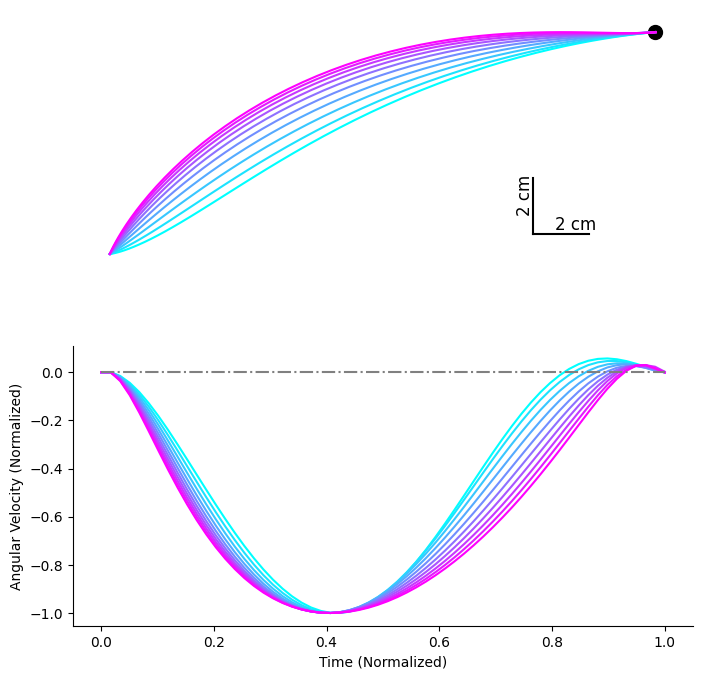

In [8]:
X0,XN = [70,110],[30,60]
start = ToCartesian(np.array(X0)/180*pi)
end = ToCartesian(np.array(XN)/180*pi)
fig,ax = plt.subplots(2,1,figsize = (8,8))
timing = .4
COLORS = get_colors_from_colormap(10,cmap_name ="cool" )
for i in range(10):
    X,Y,_,zilqg = ILQG(timing+i/10,1e4,1e1,1e-5,end,K=60,start = start,Delay = 0.06,Noise=True,plot = False)
    ax[0].plot(X,Y,color = COLORS[i])
    ax[1].plot(np.linspace(0,1,len(zilqg[:,1])),zilqg[:,2]/np.max(np.abs(zilqg[:,2])),color = COLORS[i])
ax[0].set_aspect("equal")
ax[0].axis("off")
ax[0].set_ylim(25,50)
ax[0].scatter([end[0]],[end[1]],color = "black",s=100)
ax[1].plot(np.linspace(0,1,100),np.zeros(100),color = "grey",linestyle = "-.")
ax[0].plot(np.linspace(15,20,100),np.ones(100)*30,color = "black")
ax[0].plot(np.ones(100)*15,np.linspace(30,35,100),color = "black")
ax[0].text(17,30.4,"2 cm",fontsize= 12)
ax[0].text(13.5,32,"2 cm",fontsize= 12,rotation = 90)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_xlabel("Time (Normalized)")
ax[1].set_ylabel("Angular Velocity (Normalized)")




Text(0.5, 0, 'Movement Time')

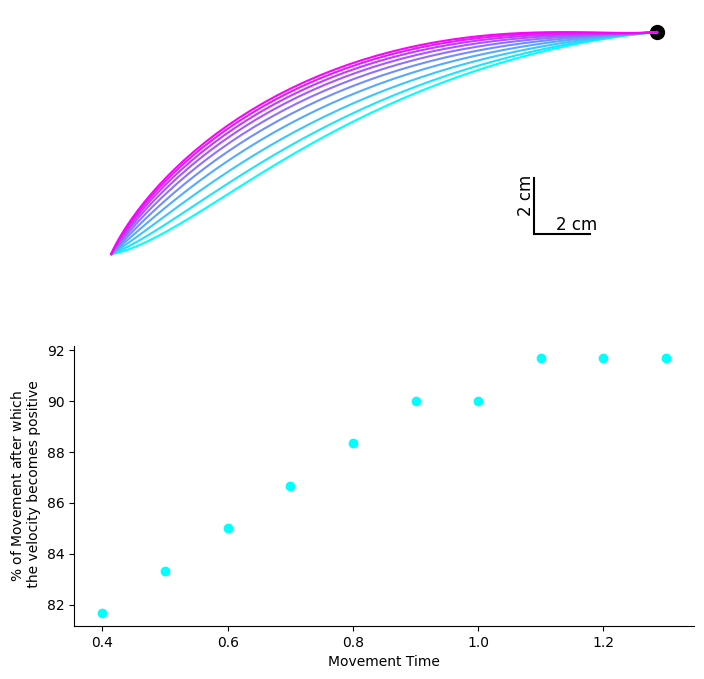

In [9]:
X0,XN = [70,110],[30,60]
start = ToCartesian(np.array(X0)/180*pi)
end = ToCartesian(np.array(XN)/180*pi)
fig,ax = plt.subplots(2,1,figsize = (8,8))
timing = .4
COLORS = get_colors_from_colormap(10,cmap_name ="cool" )
positive_velocity = []
timings = []
for i in range(10):
    X,Y,_,zilqg = ILQG(timing+i/10,1e4,1e1,1e-5,end,K=60,start = start,Delay = 0.06,Noise=True,plot = False)
    ax[0].plot(X,Y,color = COLORS[i])
    positive_velocity.append(np.argmax(zilqg[:,2] > 0)/60)
    timings.append(timing+i/10)
ax[0].set_aspect("equal")
ax[0].axis("off")
ax[0].set_ylim(25,50)
ax[0].scatter([end[0]],[end[1]],color = "black",s=100)

ax[0].plot(np.linspace(15,20,100),np.ones(100)*30,color = "black")
ax[0].plot(np.ones(100)*15,np.linspace(30,35,100),color = "black")
ax[0].text(17,30.4,"2 cm",fontsize= 12)
ax[0].text(13.5,32,"2 cm",fontsize= 12,rotation = 90)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].scatter(timings,np.array(positive_velocity)*100,color = "cyan")
ax[1].set_ylabel("$\%$ of Movement after which\n the velocity becomes positive")
ax[1].set_xlabel("Movement Time")



Text(0.5, 0, 'Movement Time')

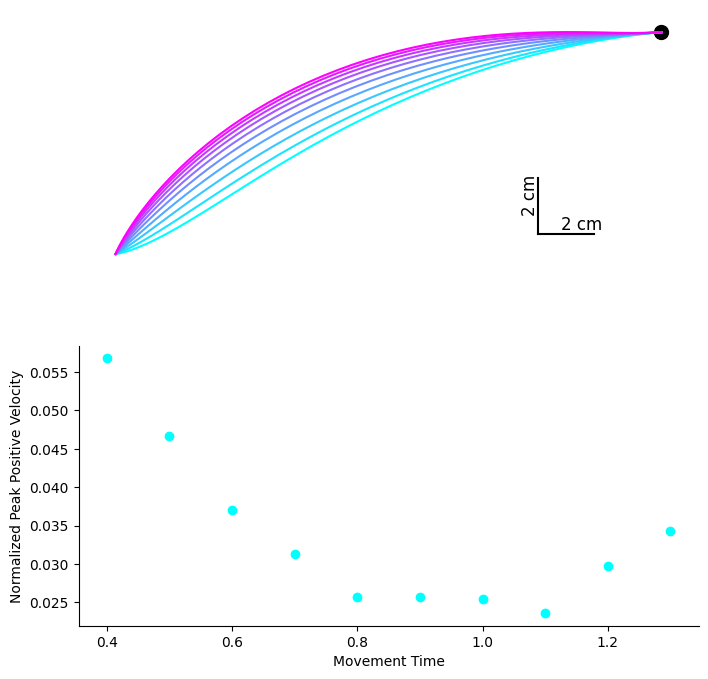

In [10]:
X0,XN = [70,110],[30,60]
start = ToCartesian(np.array(X0)/180*pi)
end = ToCartesian(np.array(XN)/180*pi)
fig,ax = plt.subplots(2,1,figsize = (8,8))
timing = .4
COLORS = get_colors_from_colormap(10,cmap_name ="cool" )
positive_velocity = []
timings = []
for i in range(10):
    X,Y,_,zilqg = ILQG(timing+i/10,1e4,1e1,1e-5,end,K=60,start = start,Delay = 0.06,Noise=True,plot = False)
    ax[0].plot(X,Y,color = COLORS[i])
    positive_velocity.append(np.max(zilqg[:,2])/np.max(np.abs(zilqg[:,2])))
    timings.append(timing+i/10)
ax[0].set_aspect("equal")
ax[0].axis("off")
ax[0].set_ylim(25,50)
ax[0].scatter([end[0]],[end[1]],color = "black",s=100)

ax[0].plot(np.linspace(15,20,100),np.ones(100)*30,color = "black")
ax[0].plot(np.ones(100)*15,np.linspace(30,35,100),color = "black")
ax[0].text(17,30.4,"2 cm",fontsize= 12)
ax[0].text(13.5,32,"2 cm",fontsize= 12,rotation = 90)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].scatter(timings,np.array(positive_velocity),color = "cyan")
ax[1].set_ylabel("Normalized Peak Positive Velocity")
ax[1].set_xlabel("Movement Time")

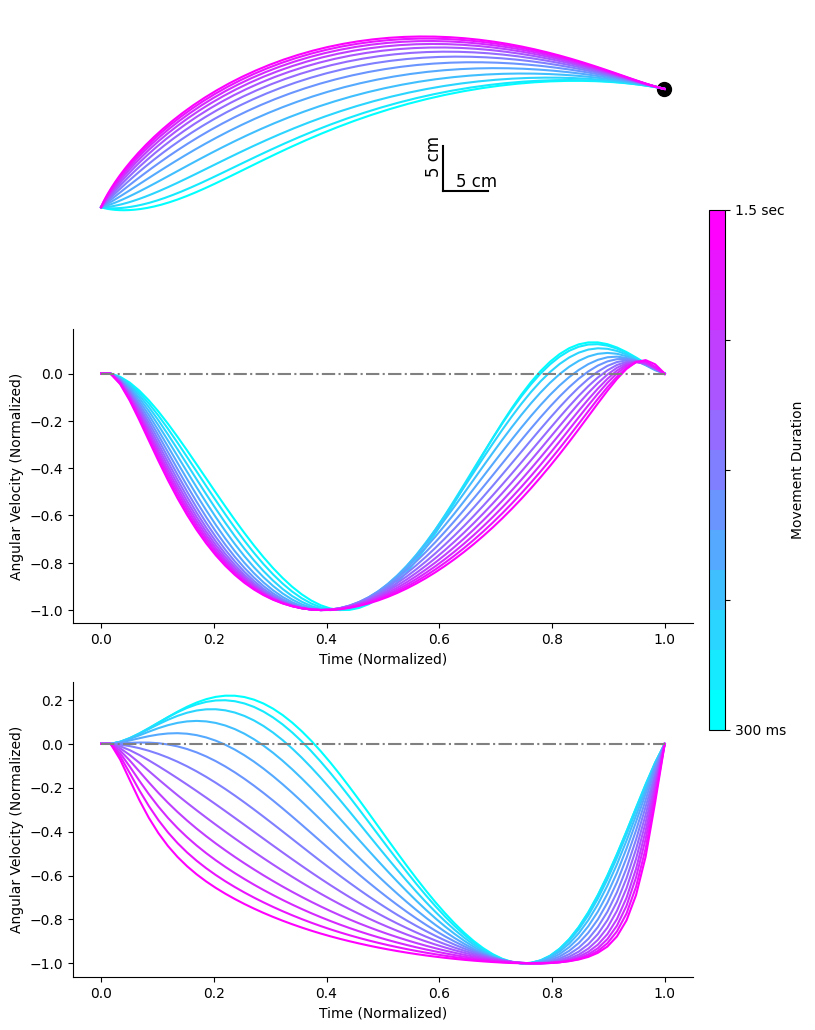

In [39]:
X0,XN = [70,110],[20,50]
start = ToCartesian(np.array(X0)/180*pi)
end = ToCartesian(np.array(XN)/180*pi)
fig,ax = plt.subplots(3,1,figsize = (8,13))
timing = .3
Num_traces = 13
COLORS = get_colors_from_colormap(Num_traces,cmap_name ="cool" )
cmap = ListedColormap(COLORS)  # Create a colormap from the array of colors
norm = Normalize(vmin=0, vmax=Num_traces-1)  # Normalize values to match the range of indices


# Add a colorbar to represent fast to slow movements
cax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # ScalarMappable needs a dummy array
cbar = plt.colorbar(sm, cax=cax, ticks=np.linspace(0, Num_traces-1, 5))  # Add colorbar
cbar.set_label('Movement Duration')  # Label the colorbar
cbar.ax.set_yticklabels(['300 ms', '', '', '', '1.5 sec'])  # Custom tick labels


for i in range(Num_traces):
    X,Y,_,zilqg = ILQG(timing+i/10,1e4,1e1,1e-5,end,K=60,start = start,Delay = 0.06,Noise=True,plot = False)
    ax[0].plot(X,Y,color = COLORS[i])
    ax[1].plot(np.linspace(0,1,len(zilqg[:,1])),zilqg[:,2]/np.max(np.abs(zilqg[:,2])),color = COLORS[i])
    ax[2].plot(np.linspace(0,1,len(zilqg[:,1])),zilqg[:,3]/np.max(np.abs(zilqg[:,3])),color = COLORS[i])
ax[0].set_aspect("equal")
ax[0].axis("off")
ax[0].set_ylim(25,50)
ax[0].scatter([end[0]],[end[1]],color = "black",s=100)
ax[0].plot(np.linspace(15,20,100),np.ones(100)*30,color = "black")
ax[0].plot(np.ones(100)*15,np.linspace(30,35,100),color = "black")
ax[0].text(16.5,30.4,"5 cm",fontsize= 12)
ax[0].text(13,32,"5 cm",fontsize= 12,rotation = 90)
for l in range(1,3):
    ax[l].plot(np.linspace(0,1,100),np.zeros(100),color = "grey",linestyle = "-.")
    ax[l].spines['top'].set_visible(False)
    ax[l].spines['right'].set_visible(False)
    ax[l].set_xlabel("Time (Normalized)")
    ax[l].set_ylabel("Angular Velocity (Normalized)")

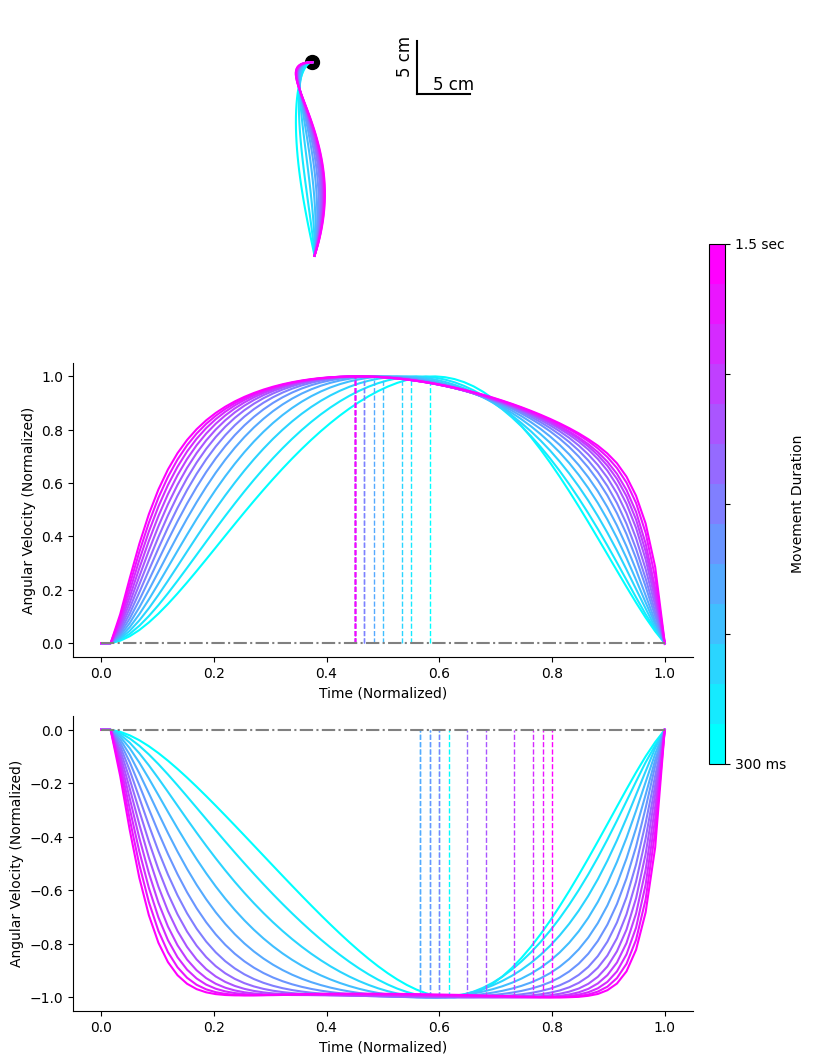

In [7]:
X0,XN = [42,90],[90,0]
start = ToCartesian(np.array(X0)/180*pi)
end = ToCartesian(np.array(XN)/180*pi)
fig,ax = plt.subplots(3,1,figsize = (8,13))
timing = .3
Num_traces = 13
COLORS = get_colors_from_colormap(Num_traces,cmap_name ="cool" )
cmap = ListedColormap(COLORS)  # Create a colormap from the array of colors
norm = Normalize(vmin=0, vmax=Num_traces-1)  # Normalize values to match the range of indices


# Add a colorbar to represent fast to slow movements
cax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # ScalarMappable needs a dummy array
cbar = plt.colorbar(sm, cax=cax, ticks=np.linspace(0, Num_traces-1, 5))  # Add colorbar
cbar.set_label('Movement Duration')  # Label the colorbar
cbar.ax.set_yticklabels(['300 ms', '', '', '', '1.5 sec'])  # Custom tick labels


for i in range(Num_traces):
    X,Y,_,zilqg = ILQG(timing+i/10,1e4,1e1,1e-5,end,K=60,start = start,Delay = 0.06,Noise=True,plot = False)
    ax[0].plot(X,Y,color = COLORS[i])
    ax[1].plot(np.linspace(0,1,len(zilqg[:,1])),zilqg[:,2]/np.max(np.abs(zilqg[:,2])),color = COLORS[i])
    ax[1].plot(np.ones(100)*np.argmax(np.abs(zilqg[:,2]))/len(zilqg[:,2]),np.linspace(0,1,100),color = COLORS[i],linestyle = "--",linewidth = 1)
    ax[2].plot(np.linspace(0,1,len(zilqg[:,1])),zilqg[:,3]/np.max(np.abs(zilqg[:,3])),color = COLORS[i])
    ax[2].plot(np.ones(100)*np.argmax(np.abs(zilqg[:,3]))/len(zilqg[:,3]),np.linspace(-1,0,100),color = COLORS[i],linestyle = "--",linewidth = 1)
ax[0].set_aspect("equal")
ax[0].axis("off")
ax[0].set_ylim(40,68)
ax[0].scatter([end[0]],[end[1]],color = "black",s=100)
ax[0].plot(np.linspace(10,15,100),np.ones(100)*60,color = "black")
ax[0].plot(np.ones(100)*10,np.linspace(60,65,100),color = "black")
ax[0].text(11.5,60.4,"5 cm",fontsize= 12)
ax[0].text(8,62,"5 cm",fontsize= 12,rotation = 90)
for l in range(1,3):
    ax[l].plot(np.linspace(0,1,100),np.zeros(100),color = "grey",linestyle = "-.")
    ax[l].spines['top'].set_visible(False)
    ax[l].spines['right'].set_visible(False)
    ax[l].set_xlabel("Time (Normalized)")
    ax[l].set_ylabel("Angular Velocity (Normalized)")

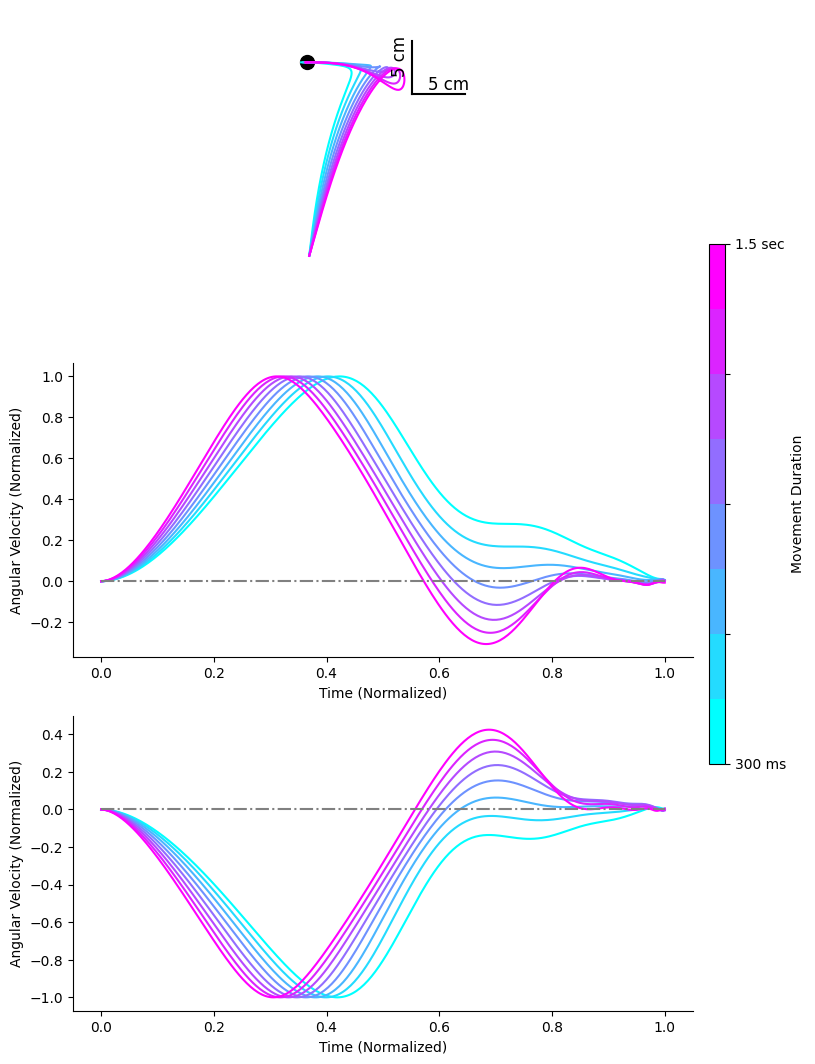

In [5]:
X0,XN = [42,90],[90,0]
start = ToCartesian(np.array(X0)/180*pi)
end = ToCartesian(np.array(XN)/180*pi)
fig,ax = plt.subplots(3,1,figsize = (8,13))
timing = .3
Num_traces = 8
COLORS = get_colors_from_colormap(Num_traces,cmap_name ="cool" )
cmap = ListedColormap(COLORS)  # Create a colormap from the array of colors
norm = Normalize(vmin=0, vmax=Num_traces-1)  # Normalize values to match the range of indices


# Add a colorbar to represent fast to slow movements
cax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # ScalarMappable needs a dummy array
cbar = plt.colorbar(sm, cax=cax, ticks=np.linspace(0, Num_traces-1, 5))  # Add colorbar
cbar.set_label('Movement Duration')  # Label the colorbar
cbar.ax.set_yticklabels(['300 ms', '', '', '', '1.5 sec'])  # Custom tick labels


for i in range(Num_traces):
    X,Y,_,zilqg = BestLQG(timing+i/10,1e4,1e4,1e1,1e1,1e-5,1e-5,end,Num_iter=300,starting_point = start,Delay = 0,plot = False)
    ax[0].plot(X,Y,color = COLORS[i])
    ax[1].plot(np.linspace(0,1,len(zilqg[1])),zilqg[1]/np.max(np.abs(zilqg[1])),color = COLORS[i])
    ax[2].plot(np.linspace(0,1,len(zilqg[1])),zilqg[4]/np.max(np.abs(zilqg[4])),color = COLORS[i])
ax[0].set_aspect("equal")
ax[0].axis("off")
ax[0].set_ylim(40,68)
ax[0].scatter([end[0]],[end[1]],color = "black",s=100)
ax[0].plot(np.linspace(10,15,100),np.ones(100)*60,color = "black")
ax[0].plot(np.ones(100)*10,np.linspace(60,65,100),color = "black")
ax[0].text(11.5,60.4,"5 cm",fontsize= 12)
ax[0].text(8,62,"5 cm",fontsize= 12,rotation = 90)
for l in range(1,3):
    ax[l].plot(np.linspace(0,1,100),np.zeros(100),color = "grey",linestyle = "-.")
    ax[l].spines['top'].set_visible(False)
    ax[l].spines['right'].set_visible(False)
    ax[l].set_xlabel("Time (Normalized)")
    ax[l].set_ylabel("Angular Velocity (Normalized)")

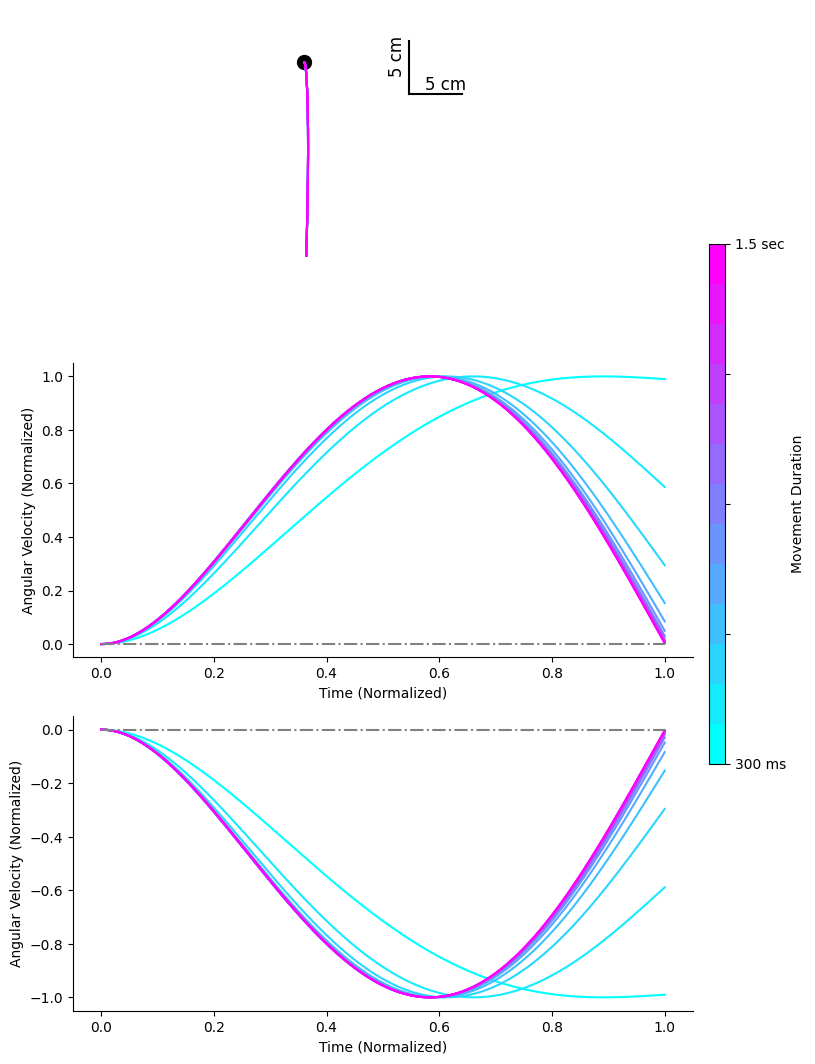

In [10]:
X0,XN = [42,90],[90,0]
start = ToCartesian(np.array(X0)/180*pi)
end = ToCartesian(np.array(XN)/180*pi)
fig,ax = plt.subplots(3,1,figsize = (8,13))
timing = .3
Num_traces = 13
COLORS = get_colors_from_colormap(Num_traces,cmap_name ="cool" )
cmap = ListedColormap(COLORS)  # Create a colormap from the array of colors
norm = Normalize(vmin=0, vmax=Num_traces-1)  # Normalize values to match the range of indices


# Add a colorbar to represent fast to slow movements
cax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # ScalarMappable needs a dummy array
cbar = plt.colorbar(sm, cax=cax, ticks=np.linspace(0, Num_traces-1, 5))  # Add colorbar
cbar.set_label('Movement Duration')  # Label the colorbar
cbar.ax.set_yticklabels(['300 ms', '', '', '', '1.5 sec'])  # Custom tick labels


for i in range(Num_traces):
    X,Y,_,zilqg = Feedback_Linearization(timing+i/10,1e4,1e4,1e1,1e1,1e-5,1e-5,end,Num_iter=300,starting_point = start,Delay = 0,plot = False,ShowJ=True)
    ax[0].plot(X,Y,color = COLORS[i])
    ax[1].plot(np.linspace(0,1,len(zilqg[:,1])),zilqg[:,2]/np.max(np.abs(zilqg[:,2])),color = COLORS[i])
    ax[2].plot(np.linspace(0,1,len(zilqg[:,1])),zilqg[:,3]/np.max(np.abs(zilqg[:,3])),color = COLORS[i])
ax[0].set_aspect("equal")
ax[0].axis("off")
ax[0].set_ylim(40,68)
ax[0].scatter([end[0]],[end[1]],color = "black",s=100)
ax[0].plot(np.linspace(10,15,100),np.ones(100)*60,color = "black")
ax[0].plot(np.ones(100)*10,np.linspace(60,65,100),color = "black")
ax[0].text(11.5,60.4,"5 cm",fontsize= 12)
ax[0].text(8,62,"5 cm",fontsize= 12,rotation = 90)
for l in range(1,3):
    ax[l].plot(np.linspace(0,1,100),np.zeros(100),color = "grey",linestyle = "-.")
    ax[l].spines['top'].set_visible(False)
    ax[l].spines['right'].set_visible(False)
    ax[l].set_xlabel("Time (Normalized)")
    ax[l].set_ylabel("Angular Velocity (Normalized)")

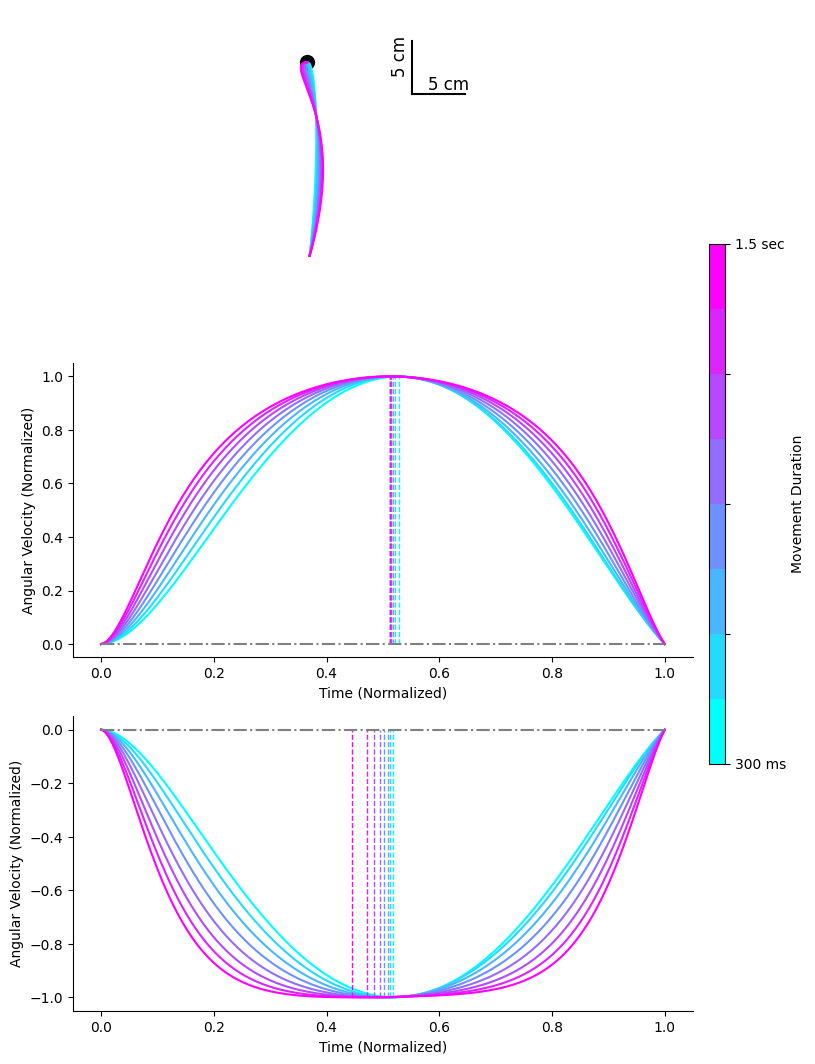

In [5]:
X0,XN = [42,90],[90,0]
start = ToCartesian(np.array(X0)/180*pi)
end = ToCartesian(np.array(XN)/180*pi)
fig,ax = plt.subplots(3,1,figsize = (8,13))
timing = .3
Num_traces = 8
COLORS = get_colors_from_colormap(Num_traces,cmap_name ="cool" )
cmap = ListedColormap(COLORS)  # Create a colormap from the array of colors
norm = Normalize(vmin=0, vmax=Num_traces-1)  # Normalize values to match the range of indices


# Add a colorbar to represent fast to slow movements
cax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # ScalarMappable needs a dummy array
cbar = plt.colorbar(sm, cax=cax, ticks=np.linspace(0, Num_traces-1, 5))  # Add colorbar
cbar.set_label('Movement Duration')  # Label the colorbar
cbar.ax.set_yticklabels(['300 ms', '', '', '', '1.5 sec'])  # Custom tick labels


for i in range(Num_traces):
    X,Y,_,zilqg = LQG(timing+i/10,1e4,1e4,1e1,1e1,1e-5,1e-5,end,Num_iter=300,starting_point = start,Delay = 0,plot = False)
    ax[0].plot(X,Y,color = COLORS[i])
    ax[1].plot(np.linspace(0,1,len(zilqg[1])),zilqg[1]/np.max(np.abs(zilqg[1])),color = COLORS[i])
    ax[1].plot(np.ones(100)*np.argmax(np.abs(zilqg[1]))/len(zilqg[1]),np.linspace(0,1,100),color = COLORS[i],linestyle = "--",linewidth = 1)
    ax[2].plot(np.linspace(0,1,len(zilqg[1])),zilqg[4]/np.max(np.abs(zilqg[4])),color = COLORS[i])
    ax[2].plot(np.ones(100)*np.argmax(np.abs(zilqg[4]))/len(zilqg[4]),np.linspace(-1,0,100),color = COLORS[i],linestyle = "--",linewidth = 1)
ax[0].set_aspect("equal")
ax[0].axis("off")
ax[0].set_ylim(40,68)
ax[0].scatter([end[0]],[end[1]],color = "black",s=100)
ax[0].plot(np.linspace(10,15,100),np.ones(100)*60,color = "black")
ax[0].plot(np.ones(100)*10,np.linspace(60,65,100),color = "black")
ax[0].text(11.5,60.4,"5 cm",fontsize= 12)
ax[0].text(8,62,"5 cm",fontsize= 12,rotation = 90)
for l in range(1,3):
    ax[l].plot(np.linspace(0,1,100),np.zeros(100),color = "grey",linestyle = "-.")
    ax[l].spines['top'].set_visible(False)
    ax[l].spines['right'].set_visible(False)
    ax[l].set_xlabel("Time (Normalized)")
    ax[l].set_ylabel("Angular Velocity (Normalized)")